# IMPORTING LIBRARIES

In [35]:
#Dataframe
import pandas as pd
#plotting
import matplotlib.pyplot as plt
import seaborn as sns
#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#utility
import re
import string
#spark
from pyspark.sql import SparkSession
from __future__ import print_function
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql import SparkSession

# LOADING DATASET

In [2]:
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='latin',
                   names=['polarity','id','date','query','user','text'])

In [3]:
#Estraggo un campione di 
data = data.sample(frac=1)
data = data[:200000]

# DATA VISUALIZATION

Dataset details target: the polarity of the tweet (0 = negative, 4 = positive)


> date : the date of the tweet (Sat May 16 23:58:44 PDT 2009)


> polarity : the polarity of the tweet (0 = negative 4 = positive)


> user : the user that tweeted (TerraScene)


> text : the text of the tweet (i'm 10x cooler than all of you)


In [4]:
print("Dataset shape: ", data.shape)

Dataset shape:  (200000, 6)


In [5]:
data.head(10)

,polarity,id,date,query,user,text
149658,0,1883501277,Fri May 22 08:39:06 PDT 2009,NO_QUERY,Linz1010,@NCenglander poor you &lt;333333
152366,0,1932722008,Tue May 26 22:04:18 PDT 2009,NO_QUERY,chloe_cullen,Just got up for work all my family are still i...
865527,4,1677475504,Sat May 02 02:16:27 PDT 2009,NO_QUERY,drkellypage,A belated #followfriday on #sorrysaturday @tom...
1482797,4,2067335897,Sun Jun 07 12:09:56 PDT 2009,NO_QUERY,MissJPretty89,I am soooooo ready to see Magic beat the Laker...
1539920,4,2180253884,Mon Jun 15 10:13:05 PDT 2009,NO_QUERY,petermaurer,"On the iPhone, it actually makes sense to use ..."
1012154,4,1881178292,Fri May 22 03:51:37 PDT 2009,NO_QUERY,TwistedHelen,@Rockergirl75 You're here! I couldn't see you
477174,0,2178111023,Mon Jun 15 07:12:37 PDT 2009,NO_QUERY,gazagoury,At work
355881,0,2044088599,Fri Jun 05 08:51:10 PDT 2009,NO_QUERY,ClaireFry,@alandavies1 Not the only one Alan! One of a s...
396168,0,2056292398,Sat Jun 06 10:52:46 PDT 2009,NO_QUERY,jatetenkins,"Turning my phone off, going for a drive. Anoth..."
50686,0,1678598246,Sat May 02 07:11:52 PDT 2009,NO_QUERY,Love__Bug,hmmm absolutley NO groceries in our house... ...


In [6]:
data['polarity'].unique()

array([0, 4])

In [7]:
#Replacing the value 4 --> 1 for ease of understanding
data['polarity'] = data['polarity'].replace(4,1)
data.head()

,polarity,id,date,query,user,text
149658,0,1883501277,Fri May 22 08:39:06 PDT 2009,NO_QUERY,Linz1010,@NCenglander poor you &lt;333333
152366,0,1932722008,Tue May 26 22:04:18 PDT 2009,NO_QUERY,chloe_cullen,Just got up for work all my family are still i...
865527,1,1677475504,Sat May 02 02:16:27 PDT 2009,NO_QUERY,drkellypage,A belated #followfriday on #sorrysaturday @tom...
1482797,1,2067335897,Sun Jun 07 12:09:56 PDT 2009,NO_QUERY,MissJPretty89,I am soooooo ready to see Magic beat the Laker...
1539920,1,2180253884,Mon Jun 15 10:13:05 PDT 2009,NO_QUERY,petermaurer,"On the iPhone, it actually makes sense to use ..."


In [8]:
data.describe()

,polarity,id
count,200000.000000,2.000000e+05
mean,0.499285,1.999486e+09
std,0.500001,1.932042e+08
min,0.000000,1.467811e+09
25%,0.000000,1.957114e+09
50%,0.000000,2.002225e+09
75%,1.000000,2.177133e+09
max,1.000000,2.329205e+09


In [11]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity==1]
negatives = data['polarity'][data.polarity==0]

print('Total lenght of the data is:           {}'.format(data.shape[0]))
print('N. of positives tagged sentences is:   {}'.format(len(positives)))
print('N. of negatives tagged sentences is:   {}'.format(len(negatives)))

Total lenght of the data is:           200000
N. of positives tagged sentences is:   99857
N. of negatives tagged sentences is:   100143


In [12]:
#funzione che riceve il testo di un tweet e lo divide, restituendo la lunghezza della lista di stringhe
def word_count(words):
  return len(words.split())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


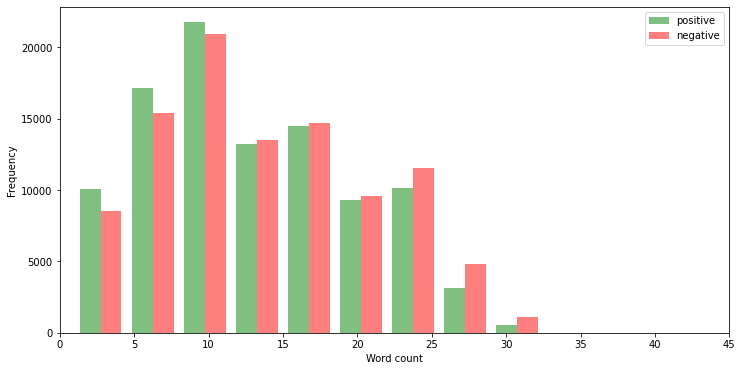

In [14]:
# plot word count distribution for both positive and negative
data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity==1]
n = data['word count'][data.polarity==0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p,n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [15]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['text']):
  words = line.split()
  for word in words:
    if(len(word)>2):
      all_words.append(word.lower())

Counter(all_words).most_common(20)

[('the', 64637),
 ('and', 37012),
 ('you', 29438),
 ('for', 26821),
 ('have', 17570),
 ('that', 16157),
 ("i'm", 15953),
 ('just', 15580),
 ('but', 15553),
 ('with', 14203),
 ('was', 12991),
 ('not', 12768),
 ('this', 11072),
 ('get', 9964),
 ('good', 9520),
 ('like', 9386),
 ('are', 9354),
 ('all', 9251),
 ('out', 8563),
 ("it's", 8113)]

# DATA PROCESSING

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


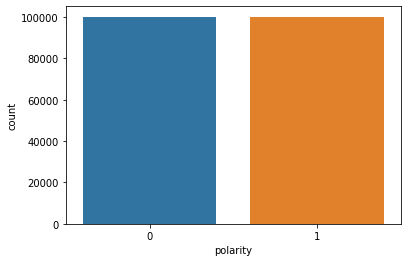

In [17]:
%matplotlib inline
sns.countplot(data['polarity'])

In [20]:
#removing the unnecessary columns
data.drop(['date','query','user','word count'], axis=1, inplace=True)

In [21]:
data.drop('id',axis=1,inplace=True)

In [22]:
data.head(10)

,polarity,text
149658,0,@NCenglander poor you &lt;333333
152366,0,Just got up for work all my family are still i...
865527,1,A belated #followfriday on #sorrysaturday @tom...
1482797,1,I am soooooo ready to see Magic beat the Laker...
1539920,1,"On the iPhone, it actually makes sense to use ..."
1012154,1,@Rockergirl75 You're here! I couldn't see you
477174,0,At work
355881,0,@alandavies1 Not the only one Alan! One of a s...
396168,0,"Turning my phone off, going for a drive. Anoth..."
50686,0,hmmm absolutley NO groceries in our house... ...


In [23]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

polarity    0.0
text        0.0
dtype: float64

In [28]:
#converting pandas object to a string type
data['text']=data['text'].astype('str')

In [31]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'that', 'from', 'theirs', 'both', 'i', 'about', 'until', 'can', 'your', 'won', 'hadn', 'now', 'to', "hadn't", 'm', 'are', 'hasn', "weren't", 'was', 'out', 'them', 'll', 'any', "it's", 'after', 'over', "should've", 'and', 'when', 'couldn', "won't", 'further', 'no', 'wasn', 'most', 'does', 'this', 'as', 'which', 'himself', 'at', "mightn't", 'more', 'off', "shan't", 'being', 'be', "hasn't", 'my', 'few', 'ours', "haven't", "needn't", 'while', "didn't", 'other', 'will', 'weren', 'doing', "don't", "aren't", 'ain', 'down', 'have', 'she', 'here', "she's", 'hers', 'not', 'its', 'into', 'doesn', 'wouldn', "you're", 'him', "that'll", 'a', 'during', 'had', 'itself', 'her', 'isn', 'you', 'he', 'yours', "mustn't", 'aren', 'didn', 'all', 'don', 'by', 'in', 'nor', 'the', 'they', 'of', 'then', 'how', 'again', 'too', 'between', 'those', 'their', 'an', 'ourselves', 'we', 'own', 'herself', 'who'

In [32]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

The Preprocessing steps taken are:


> Lower Casing: Each text is converted to lowercase.


> Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".


> Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")


> Removing Short Words: Words with length less than 2 are removed.


> Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")


> Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)













In [33]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

def process_tweets(tweet):
  #Lower casing
  tweet=tweet.lower()
  tweet=tweet[1:]
  #Removing all URls
  tweet=re.sub(urlPattern,'',tweet)
  #Removing all @username
  tweet=re.sub(userPattern,'',tweet)
  #Remove punctualizations
  tweet = tweet.translate(str.maketrans("","",string.punctuation))
  #tokenizing words
  tokens=word_tokenize(tweet)
  #Removing Stop Words
  final_tokens = [w for w in tokens if w not in stopword]
  #reducing a word to its word stem
  wordLemm = WordNetLemmatizer() 
  finalwords=[]
  for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
  return ' '.join(finalwords)

In [36]:
data['processed_tweets']=data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete')

Text Preprocessing complete


In [37]:
data.head(10)

,polarity,text,processed_tweets
149658,0,@NCenglander poor you &lt;333333,ncenglander poor lt333333
152366,0,Just got up for work all my family are still i...,ust got work family still bed
865527,1,A belated #followfriday on #sorrysaturday @tom...,belated followfriday sorrysaturday
1482797,1,I am soooooo ready to see Magic beat the Laker...,soooooo ready see magic beat lakers tonight
1539920,1,"On the iPhone, it actually makes sense to use ...",iphone actually make sense use icon others use...
1012154,1,@Rockergirl75 You're here! I couldn't see you,rockergirl75 youre couldnt see
477174,0,At work,work
355881,0,@alandavies1 Not the only one Alan! One of a s...,alandavies1 one alan one sadly select though
396168,0,"Turning my phone off, going for a drive. Anoth...",urning phone going drive another day another h...
50686,0,hmmm absolutley NO groceries in our house... ...,mmm absolutley grocery house hate day def idea...


# Convert Pandas to PySpark (Spark) DataFrame

In [ ]:
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("TwitterSentimentAnalysis.com") \
    .getOrCreate()

#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(data) 
sparkDF.printSchema()
sparkDF.show()

# DATA FEATURIZATION
TF-IDF
Term frequency-inverse document frequency (TF-IDF) is a feature vectorization method widely used in text mining to reflect the importance of a term to a document in the corpus. Denote a term by t, a document by d, and the corpus by D. Term frequency TF(t,d) is the number of times that term t appears in document d, while document frequency DF(t,D) is the number of documents that contains term t.
If we only use term frequency to measure the importance, it is very easy to over-emphasize terms that appear very often but carry little information about the document, e.g. “a”, “the”, and “of”. If a term appears very often across the corpus, it means it doesn’t carry special information about a particular document. Inverse document frequency is a numerical measure of how much information a term provides:

> IDF(t,D)=(log|D|+1)/(DF(t,D)+1)

where |D| is the total number of documents in the corpus. Since logarithm is used, if a term appears in all documents, its IDF value becomes 0. Note that a smoothing term is applied to avoid dividing by zero for terms outside the corpus. The TF-IDF measure is simply the product of TF and IDF:

> TFIDF(t,d,D)=TF(t,d)⋅IDF(t,D)

There are several variants on the definition of term frequency and document frequency. In MLlib, we separate TF and IDF to make them flexible.

> TF: Both HashingTF and CountVectorizer can be used to generate the term frequency vectors.


> IDF is an Estimator which is fit on a dataset and produces an IDFModel. The IDFModel takes feature vectors (generally created from HashingTF or CountVectorizer) and scales each feature. Intuitively, it down-weights features which appear frequently in a corpus.




In [ ]:
 tokenizer = Tokenizer(inputCol="processed_tweets", outputCol="words")
 wordsData = tokenizer.transform(sparkDF)
 hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=131072)
 featurizedData = hashingTF.transform(wordsData)

 idf = IDF(inputCol="rawFeatures", outputCol="features")
 idfModel = idf.fit(featurizedData)
 rescaledData = idfModel.transform(featurizedData)

 rescaledData.select("polarity", "features").show()